---
title: "자동차 번호 인식"
author: "Sungil Park"
date: "2024-10-11"
description: "OpenCV & pytesseract를 알아보아요" 
image: 'data/carnum.png'
---

## 이미지 전처리 레벨
 - grayscale 바꾸기
 - hsv 색공간으로 변환
 - 이진화 연산
 - blur 연산

## 번호판 바운딩 박스 처리
 - 컨투어 찾기
 - 알고리즘적 아이디어로 분자가 들어가있는 박스 찾기
- 

# 패키지

In [96]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

# 이미지 불러오기

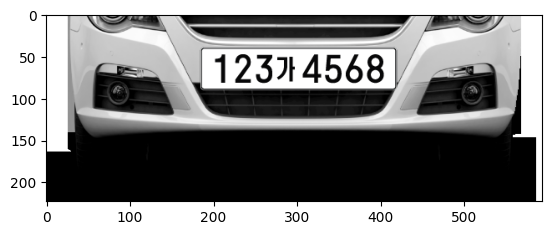

In [97]:
img_path = "data/car2.png"
img_raw = cv2.imread(img_path)

plt.imshow(cv2.cvtColor(img_raw,cv2.COLOR_BGR2RGB))
plt.show()

# 이미지 전처리

## 1. Resize

- 비율을 유지하면서 width를 500px으로

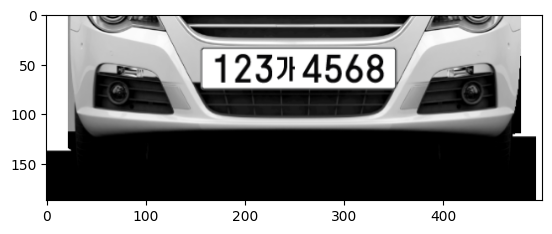

In [98]:
# width, height 지정
ratio_w = 500/img_raw.shape[1]
img_h = int(img_raw.shape[0] * ratio_w)
img_w = int(img_raw.shape[1] * ratio_w)

# resize
img_resize = cv2.resize(img_raw,(img_w, img_h))

plt.imshow(cv2.cvtColor(img_resize,cv2.COLOR_BGR2RGB))
plt.show()

## 2. GaussianBlur

- 가우시안 블러
- 이미지 노이즈 제거, 부드럽게 만들기

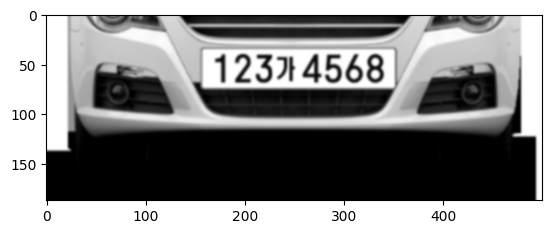

In [99]:
img_gaus = cv2.GaussianBlur(img_resize, (5,5), 0)
plt.imshow(cv2.cvtColor(img_gaus,cv2.COLOR_BGR2RGB))
plt.show()

## 3. GrayScale

- 흑백 이미지로 변환
- 이미지 색상 제거 (번호판 인식은 명암 차이가 중요)

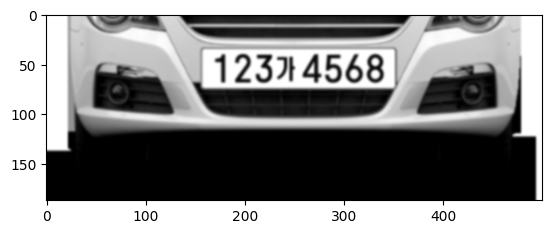

In [100]:
img_gray = cv2.cvtColor(img_gaus, cv2.COLOR_BGR2GRAY)

plt.imshow(img_gray,"gray")
plt.show()

## 4. MorphologyEX

- 모폴리지 연산
- 이미지 엣지 강조

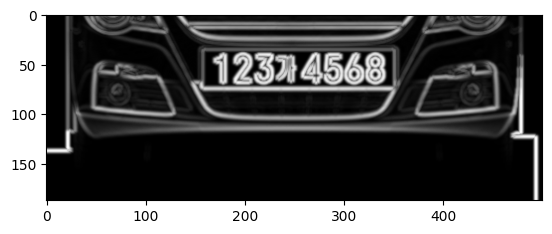

In [101]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
img_edge = cv2.morphologyEx(img_gray, cv2.MORPH_GRADIENT, kernel)

plt.imshow(img_edge,'gray')
plt.show()

## 5. Threshold

- 이미지 이진화
- 이미지를 0, 1의 값을 가진 이진 이미지로 변환
- Otsu 알고리즘으로 최적의 임계값 계산

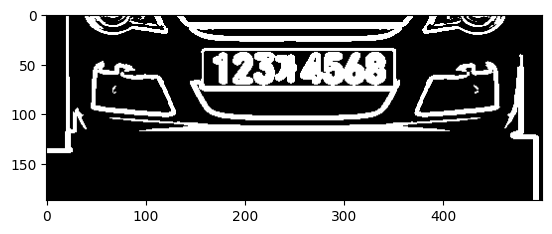

In [102]:
_, img_binary = cv2.threshold(img_edge, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(img_binary,'gray')
plt.show()

## 6. MorphologyEx (Close)

- 모폴로지 닫기 연산
- 이미지의 작은 구명을 메꿈 (번호판의 끊어진 부분을 제거)

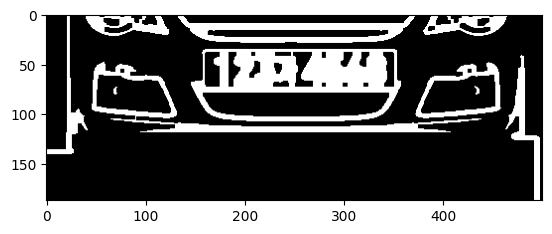

In [103]:
kernel_close = np.ones((4,4), np.uint8)
img_morph = cv2.morphologyEx(img_binary, cv2.MORPH_CLOSE, kernel_close)

plt.imshow(img_morph,'gray')
plt.show()

## 전체 과정

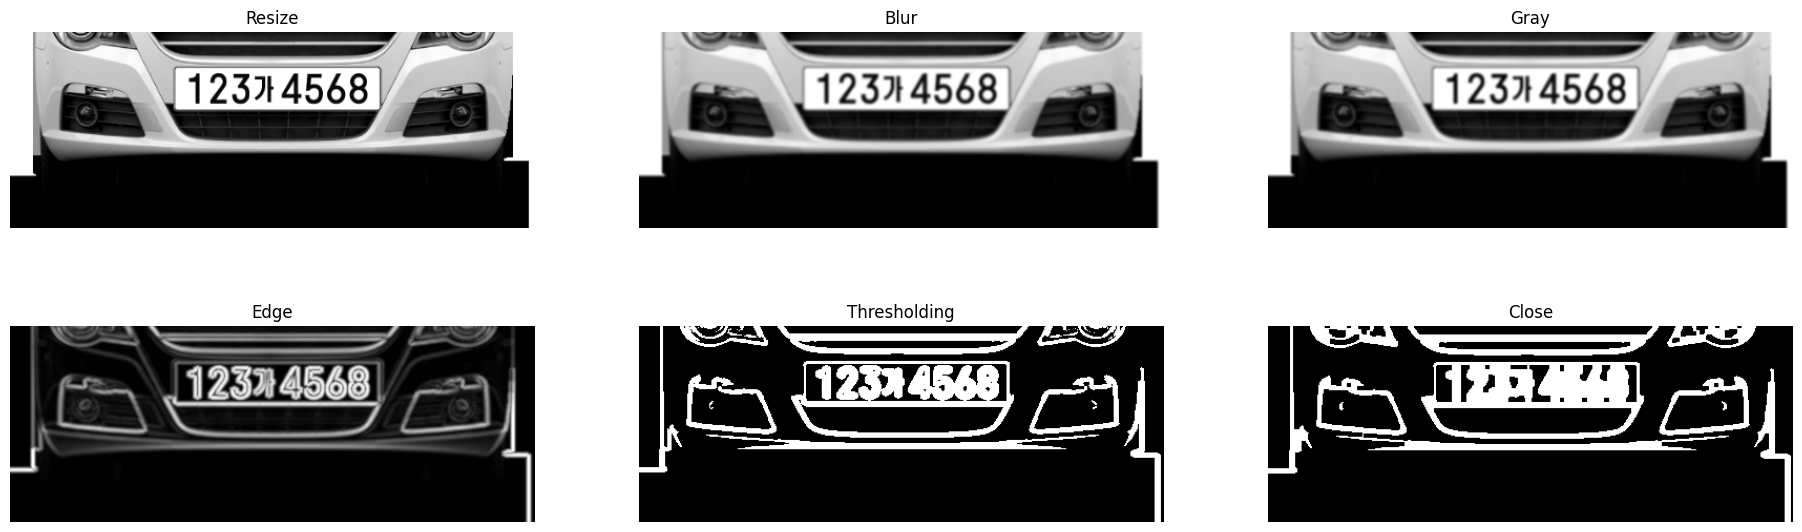

In [104]:
titles = ["Resize", "Blur", "Gray", "Edge", "Thresholding", "Close"]
images = [img_resize, img_gaus, img_gray , img_edge, img_binary, img_morph]

plt.figure(figsize=(23,7))
for i in range(len(images)):
    plt.subplot(2,3,i+1)
    if len(images[i].shape)==3:
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(images[i], "gray")
    plt.axis("off")
    plt.title(titles[i])
plt.show()

# 이미지 컨투어 찾기

- 전처리된 이미지에서 윤곽선 찾기

- `cv2.RETR_EXTERNAL` : 가장 바깥쪽 윤곽선

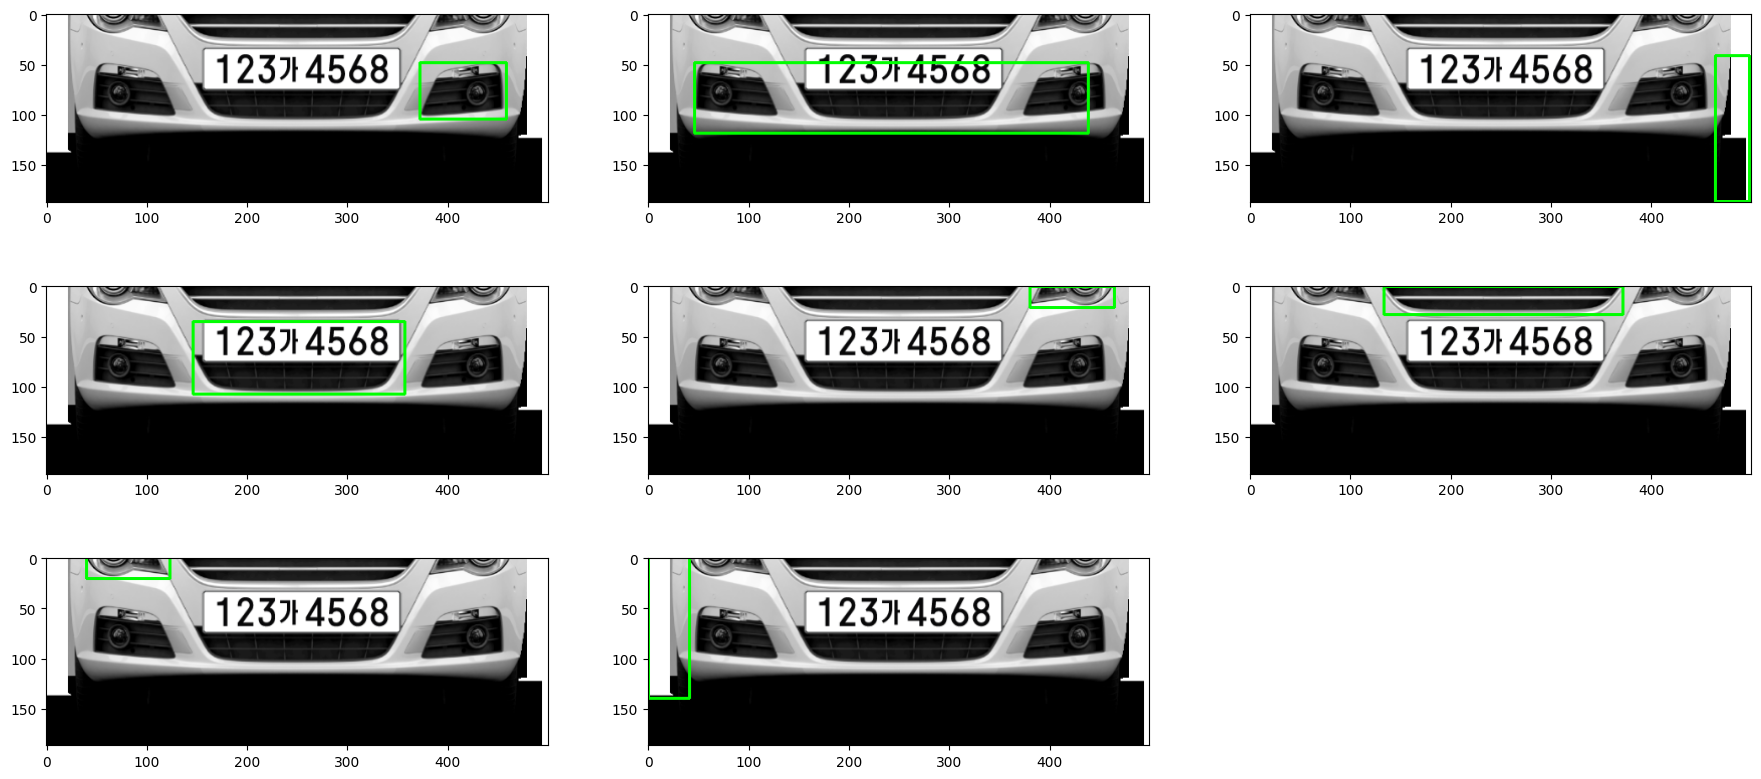

In [105]:
contour, hierarchy = cv2.findContours(img_morph, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

# 윤곽선 시각화
plt.figure(figsize=(22,10))
for i,cnt in enumerate(contour):
    x, y, w, h = cv2.boundingRect(cnt)
    img_copy = img_resize.copy()
    cv2.rectangle(img_copy, (x,y), (x+w-1, y+h-1), (0,255,0), 2)
    plt.subplot(int(len(contour)/3)+1,3,i+1)
    plt.imshow(cv2.cvtColor(img_copy,cv2.COLOR_BGR2RGB))

plt.show()

## 컨투어 중 번호판 컨투어 찾기

- `ratio > 0.5` : 컨투어 중 흰색의 비율이 0.5이상
- `w >150` : 너비가 150 이상 
- `h > 30` : 높이가 30이상

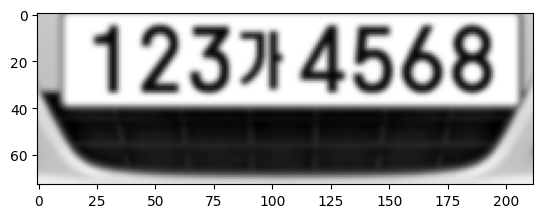

In [106]:
contour, hierarchy = cv2.findContours(img_morph, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

for cnt in contour:
    x, y, w, h = cv2.boundingRect(cnt)

    cv2.rectangle(img_resize, (x,y), (x+w-1, y+h-1), (0,255,0), 2)

    ratio = float(cv2.countNonZero(img_morph[y:y+h, x:x+w])) / (w*h)
    if ratio > 0.5 and w >150 and h > 30:
        img_sub = img_gray[y:y+h, x:x+w]
        plt.imshow(cv2.cvtColor(img_sub, cv2.COLOR_BGR2RGB))
        plt.show()    

## 번호판 영역을 이진이미지로 변환

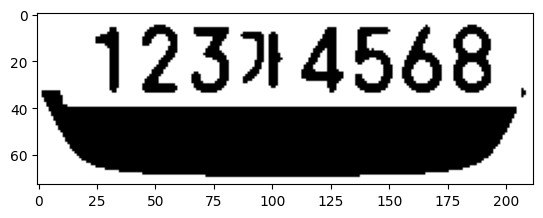

In [107]:
_, img_sub_th = cv2.threshold(img_sub, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(img_sub_th, "gray")
plt.show()

## pytesseract로 탐지

개선점
- '가' 를 7로 인식
- 이미지 아래쪽 검은 부분을 문자로 인식

In [108]:
car_num = pytesseract.image_to_string(img_sub_th, lang='kor+eng')
print(car_num)

12374568
Sy

